## Table of Contents:

* [Introduction](#Introduction)
* [Import Libraries](#import-libraries)
* [Selecting a Single Stock](#selecting_a_single_stock)
* [KPSS Test for Stationarity Test](#kpss)
* [ADF Test for Stationarity Test](#adf)
* [Selecting the Order of Differencing(d)](#d)
* [Selecting the Order of AR(p)](#p)
* [Selecting the Order of MA(q)](#q)
* [Fitting the ARIMA model](#fit)
* [Residual Plot](#resid)




## Introduction <a class="anchor" id="Introduction"></a>

ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.
In this post, we build an optimal ARIMA model from scratch and later in this post we have used PMDARIMA and Prophet to 
build the ARIMA model automatically.

## Importing the necessary libraries <a class="anchor" id="import-libraries"></a>

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
import re
import csv
import warnings
import numpy as np
import pickle
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,plot_predict
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima as pm
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import fbprophet
from prophet import Prophet
import pandas as pd
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
#import pandas_market_calendars as mcal
#import requests
#from bs4 import BeautifulSoup
from sklearn import datasets, linear_model, metrics
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import time

## Picking a single stock data<a class="anchor" id="selecting_a_single_stock"></a>

In [2]:
with open('cons_cyc_df_years.pickle', 'rb') as handle:
    cons_cyc_df_years = pickle.load(handle)
cons_cyc_df_years

{'AAN':               Open    High     Low   Close     Volume  Daily_Returns
 2006-01-03  13.900  14.276  13.617  14.187   462513.0       0.029237
 2006-01-04  14.196  14.206  13.900  13.998   327965.0      -0.013322
 2006-01-05  13.968  13.978  13.784  13.803   231487.0      -0.013931
 2006-01-06  13.940  14.058  13.705  14.058   325213.0       0.018474
 2006-01-09  14.078  14.412  14.038  14.325   780383.0       0.018993
 ...            ...     ...     ...     ...        ...            ...
 2017-11-06  36.280  36.570  35.570  35.590  1029506.0      -0.023058
 2017-11-07  35.720  35.720  34.290  34.440  1149793.0      -0.032312
 2017-11-08  35.510  36.090  34.800  35.990  1805497.0       0.045006
 2017-11-09  35.680  35.860  35.230  35.620   979951.0      -0.010281
 2017-11-10  37.600  38.060  36.260  36.590  1214968.0       0.027232
 
 [2987 rows x 6 columns],
 'ANF':               Open    High      Low   Close     Volume  Daily_Returns
 2006-01-03  54.419  54.938  53.6180  54.186  3

In [3]:
amazon_cl = cons_cyc_df_years['AMZN'][['Close']]
amazon_return = cons_cyc_df_years['AMZN'][['Daily_Returns']]
amazon_cl

,Close
2006-01-03,47.58
2006-01-04,47.25
2006-01-05,47.65
2006-01-06,47.87
2006-01-09,47.08
...,...
2017-11-06,1120.66
2017-11-07,1123.17
2017-11-08,1132.88
2017-11-09,1129.13


## KPSS test for stationarity<a class="anchor" id="kpss"></a>

KPSS is test to check for stationarity in the presence of a deterministic trend. 

Null Hypothesis(H0): Time series is stationary around a deterministic trend. 

Alternative Hypothesis(Ha): Time series has unit root, i.e., non-statinary. 

In [4]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return (kpss_output)

df = kpss_test(amazon_cl.values)
df1 = kpss_test(amazon_return.values)
print (df, df1)

Results of KPSS Test:
Results of KPSS Test:
Test Statistic            1.70966
p-value                   0.01000
Lags Used                32.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64 Test Statistic            0.031492
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The p-value reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.
So, here we can say that amazon closing price is not stationary(rejecting the H0) and for amazon return price, we fail to reject the null hypothesis, i.e., time series is sationatinary. 


## ADF test for stationarity<a class="anchor" id="adf"></a>

ADF test is for checking the stationarity.
H0: The null hypothesis of the ADF test is that the time series is non-stationary.
Ha: The alternative hypothesis of the ADF test is that the time series is stationary.     

In [5]:
result_closing = adfuller(amazon_cl.values)
result_return = adfuller(amazon_return.values)

print (result_closing)
print (result_return)

(2.9097423703974257, 1.0, 29, 2957, {'1%': -3.432563387143659, '5%': -2.8625179291294662, '10%': -2.5672905782716513}, 19642.916397494984)
(-41.231323939010906, 0.0, 1, 2985, {'1%': -3.432542607157588, '5%': -2.8625087513967085, '10%': -2.5672856921402096}, -13356.91284047806)


## How to find the order of differencing (d)<a class="anchor" id="d"></a>

The purpose of differencing it to make the time series stationary. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.



<Figure size 432x288 with 0 Axes>

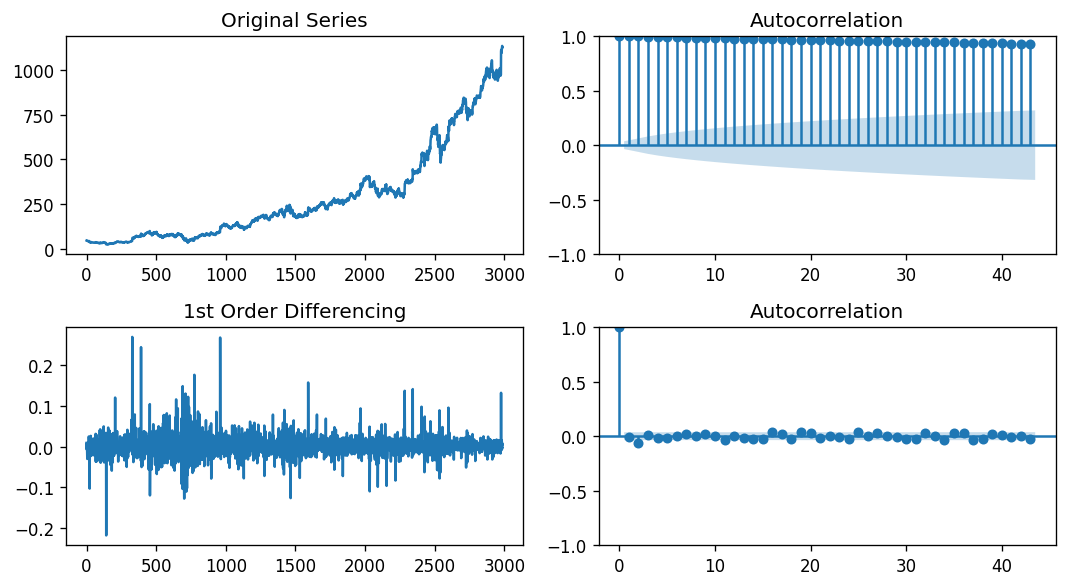

In [6]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(amazon_cl.values)
axes[0, 0].set_title('Original Series')
#plot_acf(amazon_cl.values, ax=axes[0, 1])
sm.graphics.tsa.plot_acf(amazon_cl.values, ax=axes[0, 1], lags = 43)

# 1st Differencing
axes[1, 0].plot(amazon_return.values)
axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(amazon_return.values, ax=axes[1, 1], lags = 43)
fig.tight_layout()
plt.show()

From the stationarity tests (KPSS and ADF) and the correlation plots above, it can be said that 
closing price of Amazon stock price is not stationary. However, after first differencing (daily returns), it looks like the stock price follows stationarity.
So, it seems like differencing(d) = 1 will serve the purpose, i.e., data follows the stationarity.

## How to find the order of AR term (p)<a class="anchor" id="p"></a>

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1080x600 with 0 Axes>

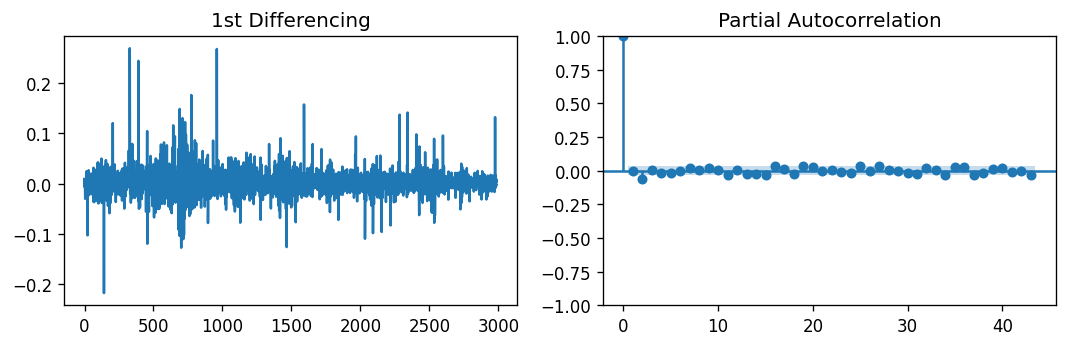

In [7]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(amazon_return.values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_pacf(amazon_return.values, ax = axes[1], lags = 43)
fig.tight_layout()
plt.show()

You can observe that the PACF lag 2 is slightly significant, just managing to cross the significance limit (blue region). So, lets start with p as 2.

## How to find the order of MA term (q)<a class="anchor" id="q"></a>

Just like how we looked at the PACF plot for the number of AR terms, we can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
From the above ACF plot, it does not seem like there is any significant lags. However, there 
is a very small lag appears to be minutely significant at lag = 2. 
So, lets start to model with (2,1,2) order and then we will play around and see which model fits the best. 


## Building ARIMA model<a class="anchor" id="fit"></a>

Now that the values of p, d and q have been determined, next we can fit the ARIMA model. 

In [8]:
model = ARIMA(amazon_cl, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2987
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9911.621
Date:                Fri, 08 Apr 2022   AIC                          19833.243
Time:                        00:24:39   BIC                          19863.251
Sample:                             0   HQIC                         19844.039
                               - 2987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0708      0.162      6.599      0.000       0.753       1.389
ar.L2         -0.5176      0.172     -3.016      0.003      -0.854      -0.181
ma.L1         -1.0466      0.165     -6.332      0.0

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under 'coef' are the weights of the respective terms.

Notice here the coefficient of all the terms are significant and the P-Value in 'P>|z|' column is highly significant (<0.05).


In [11]:
import seaborn as sns
sns.set()
def arima_model_eval_baseline(data, arima_order):
    #baseline_rmse_list = []
    #baseline_mape_list = []
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 =  data[split:]
    # walk-forward validation
    history = [x for x in train1]
    predictions = []
    for i in range(len(test1)):
    # predict
        yhat = history[-1]
        predictions.append(yhat)
    # observation
        obs = test1[i]
        history.append(obs)
        
# report performance
    mse = mean_squared_error(test1, predictions)
    baseline_rmse = np.sqrt(mse)
    baseline_mape = np.mean(np.abs(test1 - predictions)/np.abs(test1))
    #print('RMSE: %.3f' % rmse,  'MAPE: %.3f' % mape)
    baseline_rmse_list = ((np.square(np.subtract(test1,predictions))))
    baseline_mape_list = (np.abs(test1 - predictions)/np.abs(test1))
    baseline_rmse_list = list(map(lambda x :x[0], baseline_rmse_list))
    baseline_mape_list = list(map(lambda x :x[0], baseline_mape_list))
    #print (np.mean(baseline_rmse_list))
    #print (baseline_rmse_list)
    #sns.distplot(baseline_mape_list, color = 'maroon', kde = True)#kind = 'kde'
    return (baseline_mape_list, baseline_rmse, baseline_mape)
    
baseline_model = arima_model_eval_baseline(amazon_cl.values, (2,1,2))


/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


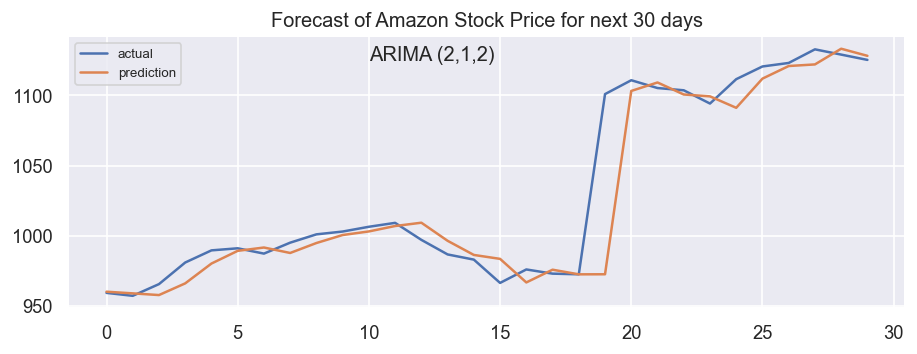

In [10]:
def arima_model_eval_manual(data, arima_order):
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 = data[split:len(data)]
    history = [x for x in train1]
    prediction = []
    for i in range(len(test1)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        warnings.simplefilter('ignore', ConvergenceWarning)
        model_forecast = model_fit.forecast()
        prediction.append(model_forecast[0])
        obs = test1[i]
        history.append(obs)
    test1 = np.array(list(map(lambda x: x[0], test1)))
    prediction = np.array(prediction)
    mse = mean_squared_error(test1,prediction)
    arima_rmse = np.sqrt(mse)
    arima_mape = np.mean(np.abs(test1 - prediction)/np.abs(test1))
    arima_rmse_list = ((np.square(np.subtract(test1,prediction))))
    arima_mape_list = (np.abs(test1 - prediction)/np.abs(test1))
    #arima_rmse_list = list(map(lambda x :x[0], arima_rmse_list))
    #arima_mape_list = list(map(lambda x :x[0], arima_mape_list))
    plt.plot(test1, label = 'actual') 
    plt.plot(prediction, label = 'prediction') 
    plt.title('Forecast of Amazon Stock Price for next 30 days')
    plt.legend(loc='upper left', fontsize=8)
    plt.text(10,1125,'ARIMA (2,1,2)', fontsize = 12)
    plt.show()
    return (arima_mape_list, arima_rmse, arima_mape)
arima_model = arima_model_eval_manual(amazon_cl.values, (2,1,2))

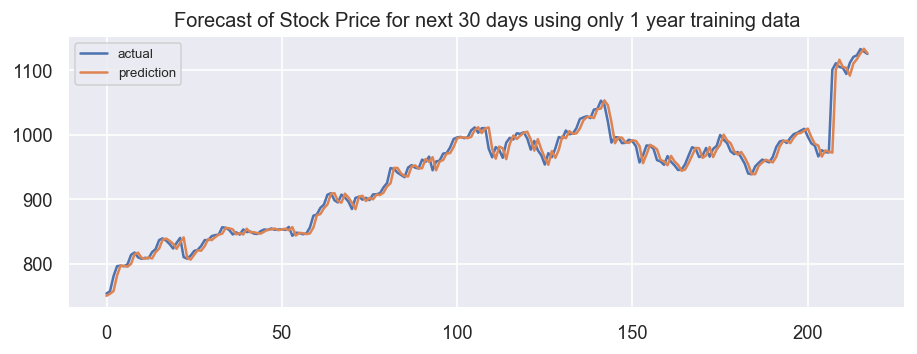

RMSE: 13.131 MAPE: 0.008


In [13]:
amazon_cl_15_17 = amazon_cl.loc[pd.to_datetime('2015'):pd.to_datetime('2018')]
amazon_cl_15_17_list = list(map(lambda x: x[0],amazon_cl_15_17.values.tolist()))
train_size = amazon_cl_15_17.loc[pd.to_datetime('2015'):pd.to_datetime('2017')].shape[0]
train_list = amazon_cl_15_17_list[:train_size]
test_list = amazon_cl_15_17_list[train_size:]
pred = []

for i in range(len(test_list)):
    arima_model = ARIMA(train_list,order = (2,1,2))
    fitted = arima_model.fit()
    warnings.simplefilter('ignore', ConvergenceWarning)
    forecast = fitted.forecast()
    pred.append(forecast[0])
    del train_list[0]
    train_list.append(test_list[i])
    
plt.plot(test_list, label = 'actual') 
plt.plot(pred, label = 'prediction') 
plt.title('Forecast of Stock Price for next 30 days using only 1 year training data')
plt.legend(loc='upper left', fontsize=8)
plt.show()
    
rmse_metric = np.sqrt(mean_squared_error(test_list,pred))
mape_metric = np.mean(np.abs(np.array(test_list) - np.array(pred))/np.abs(np.array(test_list)))
print('RMSE: %.3f' % rmse_metric,  'MAPE: %.3f' % mape_metric)

## Residual plot<a class="anchor" id="resid"></a>

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

                0
count   30.000000
mean     5.919072
std     24.466823
min    -17.144675
25%     -3.228097
50%      2.219549
75%      7.770203
max    128.486837


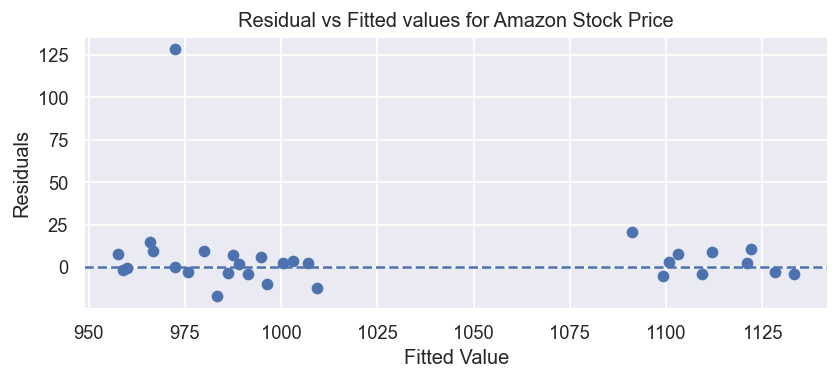

In [14]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':120})

def arima_model_eval(data, arima_order):
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 = data[split:len(data)]
    history = [x for x in train1]
    prediction = []
    for i in range(len(test1)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        warnings.simplefilter('ignore', ConvergenceWarning)
        model_forecast = model_fit.forecast()
        prediction.append(model_forecast[0])
        obs = test1[i]
        history.append(obs)
    test1 = list(map(lambda x: x[0], test1))
    residuals = [test1[i]-prediction[i] for i in range(len(test1))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    residuals = list(map(lambda x: x[0], residuals.values))
    plt.scatter(prediction, residuals)
    plt.title('Residual vs Fitted values for Amazon Stock Price')
    plt.xlabel('Fitted Value')
    plt.ylabel('Residuals')
    plt.axhline(ls = '--')
    #plt.legend(loc='upper left', fontsize=8)
    plt.show()
arima_model_eval(amazon_cl.values, (2,1,2))